In [1]:
#changelog: 

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torcheval.metrics import MulticlassConfusionMatrix
from torch.optim import lr_scheduler

from skorch import NeuralNetClassifier

from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold, cross_validate, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.manifold import TSNE

import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import os
import yaml
from operator import itemgetter

import math

import warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
pd.set_option('display.max_columns', None)

ckd_df = pd.read_excel(
    "Data/ckd_dataset.xlsx",
    usecols = "B:W,AL:AQ,AS:AY"
)

#filtering
def ckd_stage_clf(eGFR):
    if eGFR >= 90:
        return 0 #stage 1
    elif eGFR >= 60:
        return 1 #stage 2
    elif eGFR >= 45:
        return 2 #3a
    elif eGFR >= 30:
        return 3 #3b
    elif eGFR >= 15:
        return 4 #stage 4
    else:
        return 5


ckd_df.dropna(inplace=True)
eGFR_final_mean = ckd_df["eGFR(last visit)"].mean()
eGFR_final_std = ckd_df["eGFR(last visit)"].std()
filtered_ckd_df = ckd_df[(ckd_df["eGFR(last visit)"] < (eGFR_final_mean + 4*eGFR_final_std)) & (ckd_df["eGFR(last visit)"] < (.95 * ckd_df["eGFR"]))]
#filtered_ckd_df = ckd_df[(ckd_df["eGFR(last visit)"] < (eGFR_final_mean + 3*eGFR_final_std))]
filtered_ckd_df.loc[:, "CKD_stage"] = filtered_ckd_df.loc[:, "eGFR"].apply(ckd_stage_clf)

filtered_ckd_df

,gender,age,SBP,BMI,etiology of CKD,Hb,Alb,Cr,eGFR,CKD_stage,CKD category,dip-stick proteinuria,proteinuria,urinary occult blood,UPCR,UPCR category,hypertension,prevalence of CVD,diabetes,use of RAASi,use of CCB,use of diuretics,eGFR(last visit),observational duration,50%eGFR_reached,50%eGFR_duration,RRT,RRT_duration,CKD progression,CKD progression_duration,death,death_duration,development of CVD,development of CVD_duration,≥6M followed
0,2,74,120.0,23.137669,2,12.0,4.0,1.20,34.146986,3,6.0,2.0,1.0,0.0,1.253731,3.0,1,0,0,1,1,0,18.495328,37,0,37,0,37,0,37,0,37,0,37,1
2,1,74,143.0,24.554564,2,10.9,3.8,4.95,9.804696,5,12.0,3.0,1.0,0.0,1.759615,3.0,1,0,1,1,1,1,5.578057,13,0,13,1,13,1,13,0,13,0,13,1
3,1,57,139.0,28.515625,2,15.9,4.8,0.84,73.570568,1,4.0,1.0,1.0,0.0,0.513514,3.0,1,0,0,0,0,0,67.225032,37,0,37,0,37,0,37,0,37,0,37,1
4,1,32,154.0,24.582701,4,14.4,4.4,0.87,83.558305,1,1.0,-1.0,0.0,0.0,0.025000,1.0,1,0,0,0,0,0,69.171408,36,0,36,0,36,0,36,0,36,0,36,1
7,1,66,148.0,22.532285,1,10.2,3.3,5.39,9.230697,5,12.0,3.0,1.0,0.0,3.535088,3.0,1,0,1,0,1,1,8.403298,6,0,6,1,8,1,8,0,8,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,1,75,120.0,26.015635,1,11.2,3.9,2.56,20.092993,4,8.0,-1.0,0.0,0.0,0.210210,2.0,1,0,1,1,1,0,15.511510,37,0,37,0,37,0,37,0,37,0,37,1
1128,2,72,169.0,22.494988,1,6.6,2.7,3.12,12.100035,5,12.0,3.0,1.0,0.0,17.298091,3.0,1,0,1,0,1,0,9.285258,7,0,7,1,10,1,10,0,10,0,7,1
1131,1,71,154.0,24.238775,2,15.4,4.2,1.08,52.471683,2,6.0,2.0,1.0,0.0,0.760234,3.0,1,0,0,1,0,0,47.952934,38,0,38,0,38,0,38,0,38,0,38,1
1132,1,81,154.0,19.596458,2,9.0,3.5,2.00,25.747776,4,9.0,2.0,1.0,0.0,1.038526,3.0,1,1,0,1,1,1,17.923736,37,0,37,0,37,0,37,0,37,0,37,1


In [2]:
#loading in yaml for hyperparameters

with open("autoencoder_hyperparameters.yaml", "r") as file:
    hyperparameters = yaml.safe_load(file)

training_hyperparameters = hyperparameters["training"]

fold_count, epoch_count, batch_size, learning_rate, weight_decay, patience = itemgetter("fold_count", 
                                                                                        "epoch_count", 
                                                                                        "batch_size", 
                                                                                        "learning_rate", 
                                                                                        "weight_decay", 
                                                                                        "patience")(training_hyperparameters)

In [3]:
#loading in the dataset
scaler = MinMaxScaler()
x_vals = filtered_ckd_df.drop(columns=["gender",
                                       "age",
                                       "Cr",
                                       "eGFR",
                                       "CKD_stage",
                                       "eGFR(last visit)"]).values
norm_x_vals = scaler.fit_transform(x_vals)

class ckdDataset(Dataset):
    def __init__(self):
        self.data = filtered_ckd_df
        self.x = torch.tensor(norm_x_vals,
                              dtype=torch.float32,
                              device=device,
                              requires_grad=True)
        self.y = torch.tensor(filtered_ckd_df.loc[:, "CKD_stage"].values,
                              dtype=torch.float32,
                              device=device,
                              requires_grad=True)
        self.y = self.y.type(torch.long)
        self.x_size = self.x.size
        self.y_size = self.y.size
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x,
                                                                                self.y,
                                                                                test_size=0.2,
                                                                                shuffle=True)

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

ckd_dataset = ckdDataset()
ckd_dataloader = DataLoader(ckd_dataset, 
                            batch_size=batch_size,
                            shuffle=True)

In [4]:
#autoencoder structure initialization
class ckdAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
        )
    
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 29),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)


In [5]:
#autoencoder training
training_loss_list = []
testing_loss_list = []

ckd_autoencoder = ckdAutoencoder()
loss_func = nn.MSELoss()
optimizer = optim.AdamW(ckd_autoencoder.parameters(),
                       lr=learning_rate,
                       weight_decay=weight_decay)

for epoch in range(epoch_count):
    ckd_autoencoder.train()
    for (x_batch, _) in ckd_dataloader:
        x_train_pred = ckd_autoencoder(x_batch)
        training_loss = loss_func(x_train_pred, x_batch)
        optimizer.zero_grad()
        training_loss.backward(retain_graph=True)
        optimizer.step()

    training_loss = training_loss.item()
    training_loss_list.append(training_loss)
    
    ckd_autoencoder.eval()
    with torch.inference_mode():
        x_test_pred = ckd_autoencoder(ckd_dataset.x_test)
        testing_loss = loss_func(x_test_pred, ckd_dataset.x_test)

    testing_loss = testing_loss.item()
    testing_loss_list.append(testing_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}, Training loss: {training_loss}, Testing loss: {testing_loss}")

Epoch: 10, Training loss: 0.07316763699054718, Testing loss: 0.06403584778308868
Epoch: 20, Training loss: 0.06127159669995308, Testing loss: 0.05770999938249588
Epoch: 30, Training loss: 0.06342004239559174, Testing loss: 0.05714127793908119
Epoch: 40, Training loss: 0.0574161671102047, Testing loss: 0.048226360231637955
Epoch: 50, Training loss: 0.05911315977573395, Testing loss: 0.04505104571580887
Epoch: 60, Training loss: 0.0433831587433815, Testing loss: 0.04359490051865578
Epoch: 70, Training loss: 0.042125578969717026, Testing loss: 0.04226561635732651
Epoch: 80, Training loss: 0.04003116488456726, Testing loss: 0.040490198880434036
Epoch: 90, Training loss: 0.04351041093468666, Testing loss: 0.03858024254441261
Epoch: 100, Training loss: 0.038956258445978165, Testing loss: 0.03575945273041725


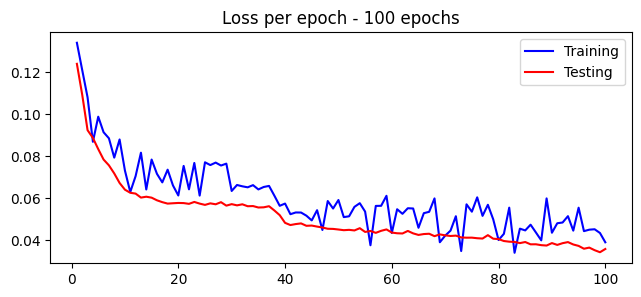

In [6]:
loss_fig, loss_ax = plt.subplots(figsize=(7.5,3))
plt.plot(range(1,len(training_loss_list)+1), training_loss_list, color="blue")
plt.plot(range(1,len(testing_loss_list)+1), testing_loss_list, color="red")

loss_ax.set_title(f"Loss per epoch - {epoch_count} epochs")
loss_ax.legend(["Training", "Testing"])
#loss_ax.set_xticks(range(0, (epoch_count * fold_count + 1), 50))

Testing loss: 0.03575945273041725


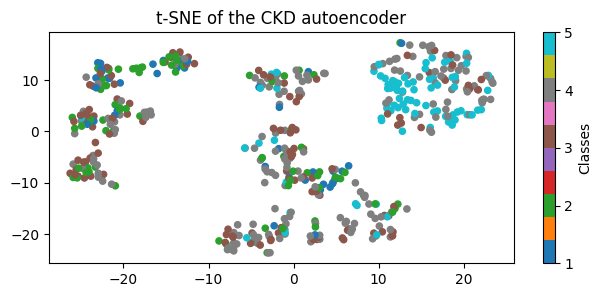

In [7]:
ckd_autoencoder.eval()
with torch.inference_mode():
    x_test_pred = ckd_autoencoder(ckd_dataset.x_test)
    testing_loss = loss_func(x_test_pred, ckd_dataset.x_test)
    encoded_data = ckd_autoencoder.encode(ckd_dataset.x).numpy()    

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_data)

tsne_fig, tsne_ax = plt.subplots(figsize=(7.5, 3))
tsne_plot = tsne_ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=ckd_dataset.y.numpy(), cmap="tab10", s=20)
plt.colorbar(tsne_plot, ticks=range(0, 6), label = "Classes")


tsne_ax.set_title("t-SNE of the CKD autoencoder")

print(f"Testing loss: {testing_loss}")

#try umap